# Description
Run a quick model fit to get initial guess of their mean value, which can then be used in the priors

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from scipy.optimize import minimize, curve_fit
from scipy.special import erf

import inv_cov_funcs as icf
import classylss
import fitsio
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')

ptile_labels = [r'$0^{th}$', r'$1^{st}$', r'$2^{nd}$', r'$3^{rd}$', r'$4^{th}$', r'$5^{th}$', r'$6^{th}$', r'$7^{th}$', r'$8^{th}$', r'$9^{th}$']
dk = 0.01
ells = [0,2]

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fitmodel_densitysplit/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034
possible_kmax = k_full[k_full<=0.343][1:] # ignore first k bin 

In [5]:
def chi2(theta, data_multipoles, k, C_inv, damped):
    '''Compute chi^2 for damped or undamped Kaiser model. 
    data_multipoles must be an array of shape (len(ells), len(k)). theta is the model parameter array.'''
    ells = [0,2]
    model_multipoles = np.empty((len(ells), len(k)))
    
    if damped:
        b1, beta, sigma = theta
        model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
        model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    else:
        b1, beta = theta
        model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
        model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)

    D_M = (data_multipoles - model_multipoles).flatten()
    return D_M@(C_inv @ D_M)

In [6]:
kmax_range = possible_kmax[:21]
Nkmax = len(kmax_range)
header = 'parameter guesses for each density bin at kmax=%s'%str(kmax_range)
Ndim = [2, 3]
# store guesses for both models for all denisty and k bins
b1_guesses, beta_guesses, sigma_guesses = np.full((n_ptile, Nkmax, 2), np.nan), np.full((n_ptile, Nkmax, 2), np.nan), np.full((n_ptile, Nkmax, 2), np.nan)
reduced_chi2 = np.full((n_ptile, Nkmax, 2), np.nan)

for d, damped in enumerate([False, True]):
    print('Damped: %s'%damped)
    for i in range(n_ptile):
        t1 = time.time()
        for j,kmax in enumerate(kmax_range):
            mask = np.full(len(k_full), False)
            mask = k_full <= kmax
            mask[0] = False 
            k_sliced = k_full[mask]
            Pk_ells_i = Pk_ells_full[:,:,mask][i]
            cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
            C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax)
            
            if not damped:
                start = [1,1]
                bounds = ((0, None), (None, None))
            else:
                start = [b1_guesses[i][j][0], beta_guesses[i][j][0], 10] #[1,1,3]
                bounds = ((0, None), (None, None), (None, None))
                
            s = minimize(chi2, start, args=(Pk_ells_i, k_sliced, C_inv, damped), bounds=bounds)
            b1_guesses[i][j][d] = s.x[0]
            beta_guesses[i][j][d] = s.x[1]
            if damped:
                sigma_guesses[i][j][d] = s.x[2]
            reduced_chi2[i][j][d] = s.fun / (2*len(k_sliced)+Ndim[d])
                
        t2 = time.time()
        print("Fitted %d-th percentile in %s"%(i+1,str(timedelta(seconds=t2-t1))))   
        
    if damped:
        np.savetxt('fit_prep/b1_guess_damped.txt', b1_guesses[:,:,1], header=header)
        np.savetxt('fit_prep/beta_guess_damped.txt', beta_guesses[:,:,1], header=header)
        np.savetxt('fit_prep/sigma_guess_damped.txt', sigma_guesses[:,:,1], header=header)
        np.savetxt('fit_prep/reduced_chi2_damped.txt', reduced_chi2[:,:,1], header=header)
    else:
        np.savetxt('fit_prep/b1_guess.txt', b1_guesses[:,:,0], header=header)
        np.savetxt('fit_prep/beta_guess.txt', beta_guesses[:,:,0], header=header)
        np.savetxt('fit_prep/reduced_chi2.txt', reduced_chi2[:,:,0], header=header)
    print('-'*32)

Damped: False
Fitted 1-th percentile in 0:00:01.937352
Fitted 2-th percentile in 0:00:01.570883
Fitted 3-th percentile in 0:00:01.399735
Fitted 4-th percentile in 0:00:01.369967
Fitted 5-th percentile in 0:00:01.434934
Fitted 6-th percentile in 0:00:01.302049
Fitted 7-th percentile in 0:00:01.357044
Fitted 8-th percentile in 0:00:01.397764
Fitted 9-th percentile in 0:00:01.407543
Fitted 10-th percentile in 0:00:01.436661
--------------------------------
Damped: True
Fitted 1-th percentile in 0:00:02.587667
Fitted 2-th percentile in 0:00:03.555360
Fitted 3-th percentile in 0:00:03.353456
Fitted 4-th percentile in 0:00:03.341304
Fitted 5-th percentile in 0:00:03.821076
Fitted 6-th percentile in 0:00:03.150092
Fitted 7-th percentile in 0:00:03.654819
Fitted 8-th percentile in 0:00:02.859818
Fitted 9-th percentile in 0:00:02.369612
Fitted 10-th percentile in 0:00:02.223053
--------------------------------


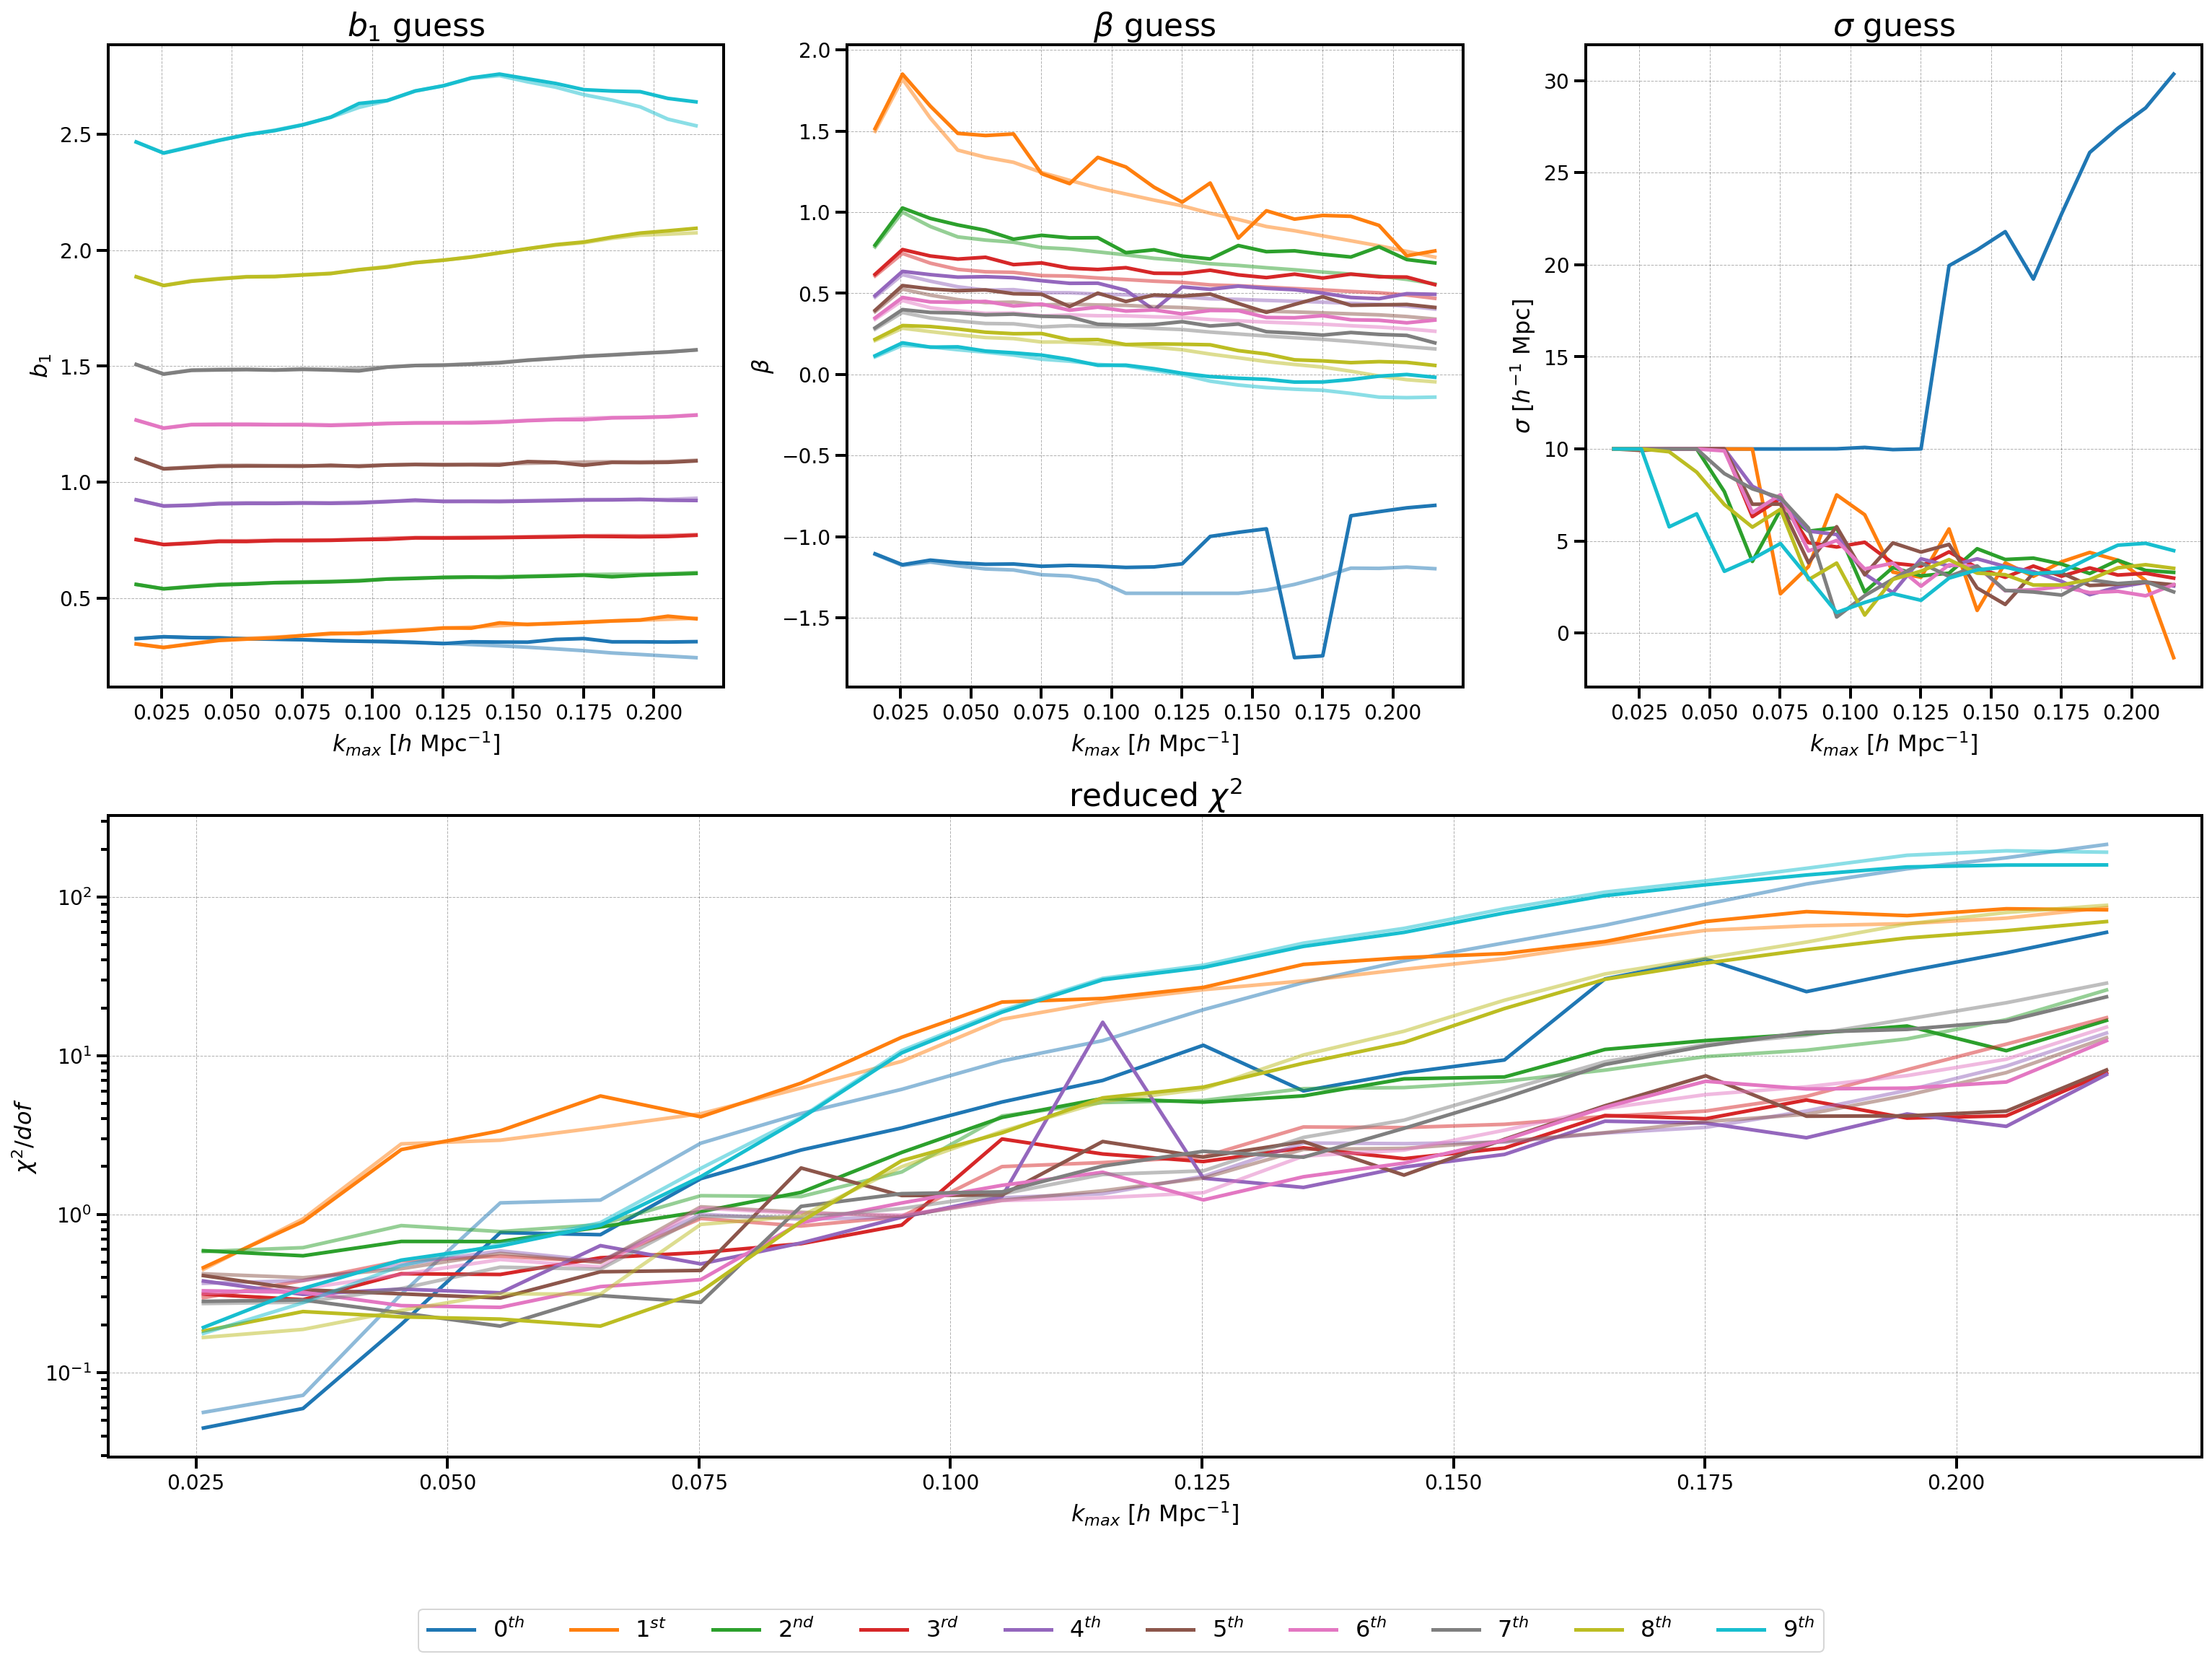

In [12]:
fig = plt.figure(figsize=(26,18))

ax_b1 = plt.subplot(2,3,1)
ax_beta = plt.subplot(2,3,2)
ax_sigma = plt.subplot(2,3,3)
ax_chi2 = plt.subplot(2,3,(4,6))

b1_guess = np.loadtxt('fit_prep/b1_guess.txt')
beta_guess = np.loadtxt('fit_prep/beta_guess.txt')
red_chi2 = np.loadtxt('fit_prep/reduced_chi2.txt')

b1_damped_guess = np.loadtxt('fit_prep/b1_guess_damped.txt')
beta_damped_guess = np.loadtxt('fit_prep/beta_guess_damped.txt')
sigma_guess = np.loadtxt('fit_prep/sigma_guess_damped.txt')
red_chi2_damped = np.loadtxt('fit_prep/reduced_chi2_damped.txt')

# b1_guess = b1_guesses[:,:,0]
# beta_guess = beta_guesses[:,:,0]
# red_chi2 = reduced_chi2[:,:,0]

# b1_damped_guess = b1_guesses[:,:,1]
# beta_damped_guess = beta_guesses[:,:,1]
# sigma_guess = sigma_guesses[:,:,1]
# red_chi2_damped = reduced_chi2[:,:,1]

for i in range(n_ptile):
    line, = ax_b1.plot(kmax_range, b1_damped_guess[i], label=ptile_labels[i])
    ax_b1.plot(kmax_range, b1_guess[i], c=line.get_color(), alpha=0.5)
    line, = ax_beta.plot(kmax_range, beta_damped_guess[i], label=ptile_labels[i]) 
    ax_beta.plot(kmax_range, beta_guess[i], c=line.get_color(), alpha=0.5) 
#     if i in [0]:
#         ax_sigma.plot(kmax_range, np.full(Nkmax, np.nan), label=ptile_labels[i])
#         continue
    ax_sigma.plot(kmax_range, sigma_guess[i], label=ptile_labels[i])    
    line, = ax_chi2.plot(kmax_range[1:], red_chi2_damped[i][1:], label=ptile_labels[i])
    ax_chi2.plot(kmax_range[1:], red_chi2[i][1:], c=line.get_color(), alpha=0.5)
    
    
ax_b1.set_title('$b_1$ guess')
ax_b1.set_xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
ax_b1.set_ylabel(r'$b_1$')

ax_beta.set_title(r'$\beta$ guess')
ax_beta.set_xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
ax_beta.set_ylabel(r'$\beta$')

ax_sigma.set_title(r'$\sigma$ guess')
ax_sigma.set_xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
ax_sigma.set_ylabel(r'$\sigma$ [$h^{-1} \ \mathrm{Mpc}$]')

ax_chi2.set_title(r'reduced $\chi^2$')
ax_chi2.set_yscale('log')
ax_chi2.set_xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
ax_chi2.set_ylabel(r'$\chi^2 / dof$')

handles, labels = ax_b1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=n_ptile)
plt.show()

#fig.savefig("plots/parameter_guesses.pdf")

### Interpretation
The pure Kaiser model is shown in transparent lines while Kaiser+FoG is plotted with solid lines. 

Choice of starting positions for pure Kaiser model is motivated by the expectation of the parameters to be of order unity. When using the same logic for the starting positions of the damped model, the guessed parameter values cluster close to the starting position for small kmax but approach the guesses of the pure model for $k_{max}>0.08$. 
When using the guesses of the pure model as the starting positions for the damped one, the guessed parameters of the two models are almost identical and only start to deviate at large $k_{max}$

For $\sigma$ there is no clearly visible trend. However, it becomes apparent that up to some $k^*_{max}$, the data cannot inform the parameter value, causing it to remain at the initial value passed to the minimizer. This is expected as the damping factor only differs from 1 when k is large. In the MCMC analysis we therefore expect to find a roughly flat posterior of $\sigma$ for $k_{max}<k^*_{max}$ and a non flat posterior for $k_{max}>k^*_{max}$. As the guesses value of $\sigma$ does not follow a nice trend like $b_1, \beta$, it is best to stick to a uniform prior. Note that for the 0th density bin, the fit is significantly improved by a large value of $\sigma$. Below one can plot a polynomial or Fermi-Dirac like interpolation for $\sigma$, trying to capture the step-function behavior.

Further note that a value of $\sigma$ of order unity, is expected via dimensional analysis and interpreting $\sigma$ to be related to the velocity dispersion of galaxies: Hubble law relates distance and velocity units: $v[km/s] = 100[km/s/Mpc]*h*d[Mpc]$. From argument of FoG exponential get $[\sigma] = Mpc/h$ i.e. distance unit. In velocity units this corresponds to $\sigma[km/s] = 100[km/s/Mpc]*h*\frac{[Mpc]}{h} = 100 km/s.$ From observations, the velocity dispersion of galaxies is usually a few hundred $km/s$. Hence we expect $\sigma$ of order unity.

I also considered using a global minimizer instead of a the local `scipy.optimize.minimize`. For both models the parameter guesses do not follow a clear trend and need roughly 45 times longer to be found. This might be due to not using the full potential of the global minimizers but in the spirit of obtaining a fast guess for the parameter mean value, I did not investigate this approach further. 

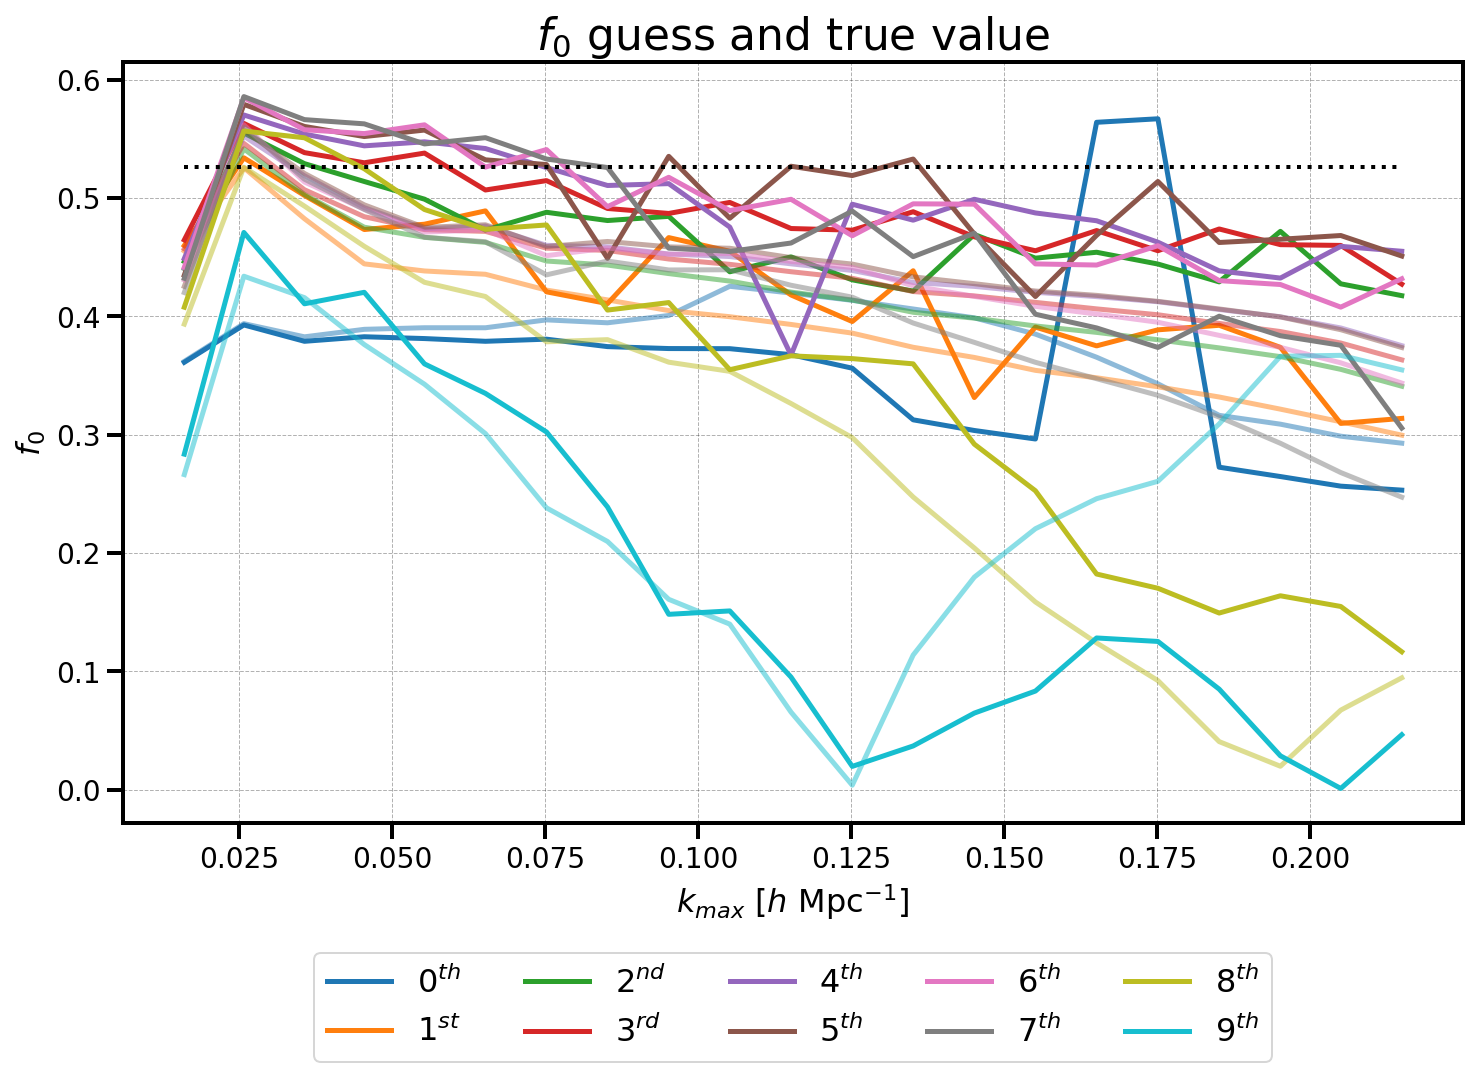

In [8]:
for i in range(n_ptile):
    line, = plt.plot(kmax_range, np.abs(b1_damped_guess[i]*beta_damped_guess[i]), label=ptile_labels[i])
    plt.plot(kmax_range, np.abs(b1_guess[i]*beta_guess[i]), c=line.get_color(), alpha=0.5)
    
plt.hlines(cosmo.scale_independent_growth_rate(0), kmax_range[0], kmax_range[-1], linestyle='dotted', color='k', linewidth=2)
plt.title('$f_0$ guess and true value')
plt.xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
plt.ylabel(r'$f_0$')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

Note that for some bins $f_0$ would be negative. By using the symmetry of the parameter space about $b_1=0$ we can enforce $f_0>0$.

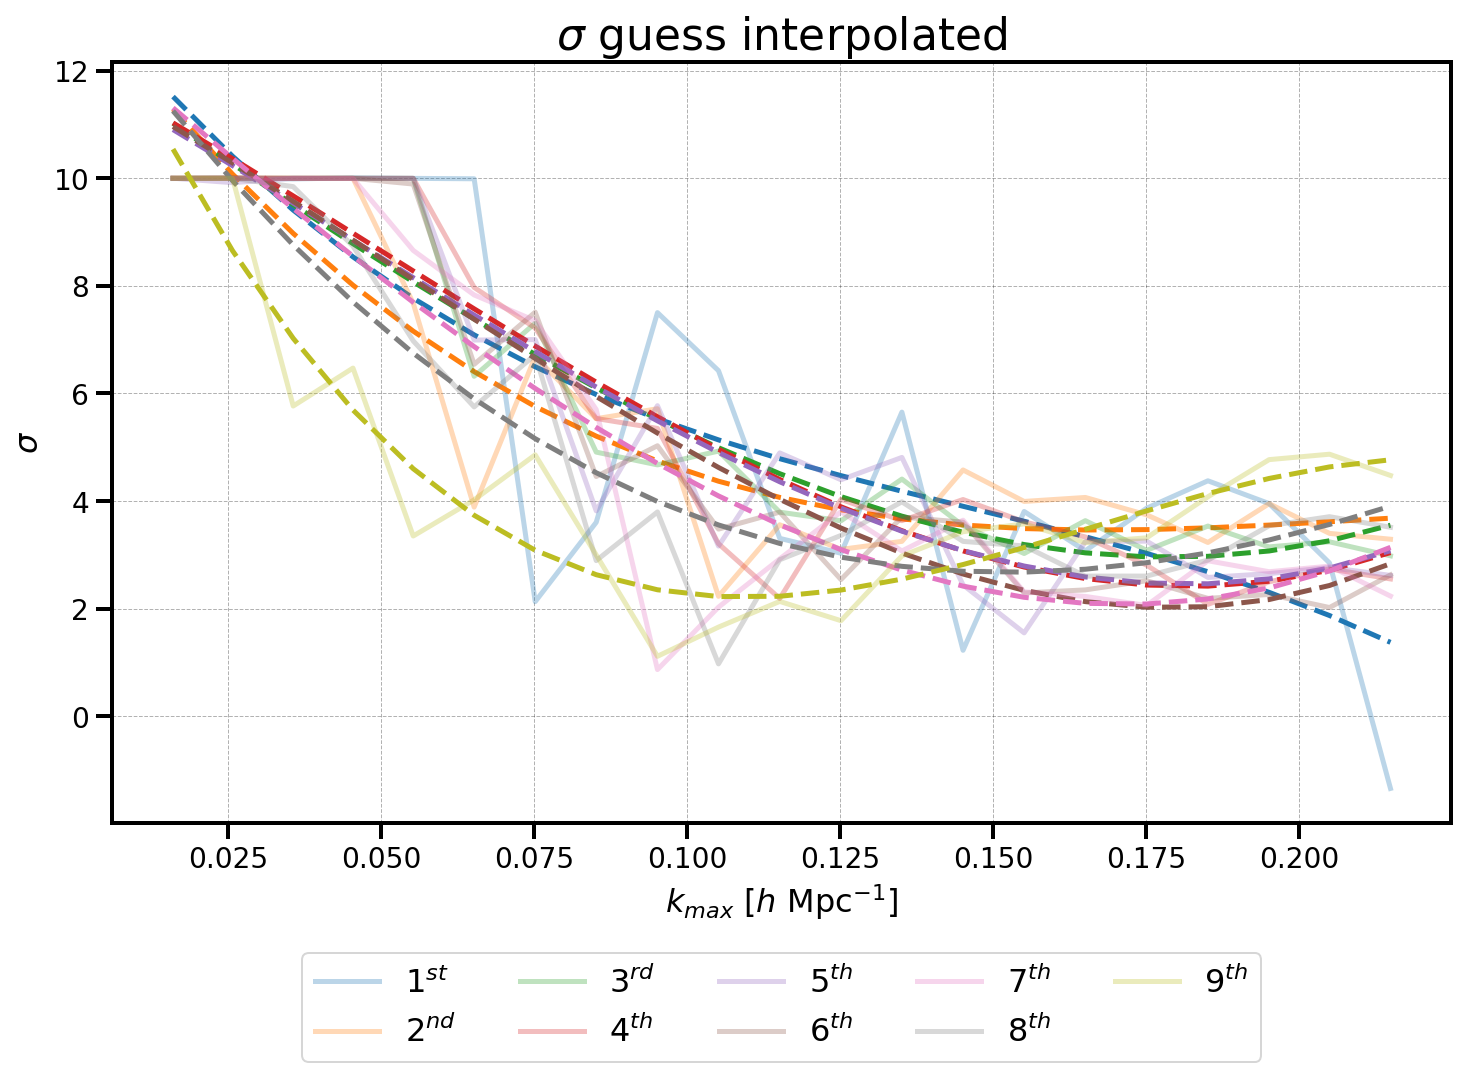

In [9]:
poly_degree = int(3)

for i in range(n_ptile):
    if i in [0]:
        continue
    trend = np.poly1d(np.polyfit(kmax_range, sigma_guess[i], poly_degree))
    line, = plt.plot(kmax_range, sigma_guess[i], label=ptile_labels[i], alpha=0.3)
    plt.plot(kmax_range, trend(kmax_range), c=line.get_color(), linestyle='--')
    
plt.title('$\sigma$ guess interpolated')
plt.xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
plt.ylabel(r'$\sigma$')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [10]:
def FD_like(k, a, b, c, d):
    return a + b/(1+np.exp(c*(k-d)))

/tmp/ipykernel_2476907/631430280.py:2: RuntimeWarning: overflow encountered in exp
  return a + b/(1+np.exp(c*(k-d)))
/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


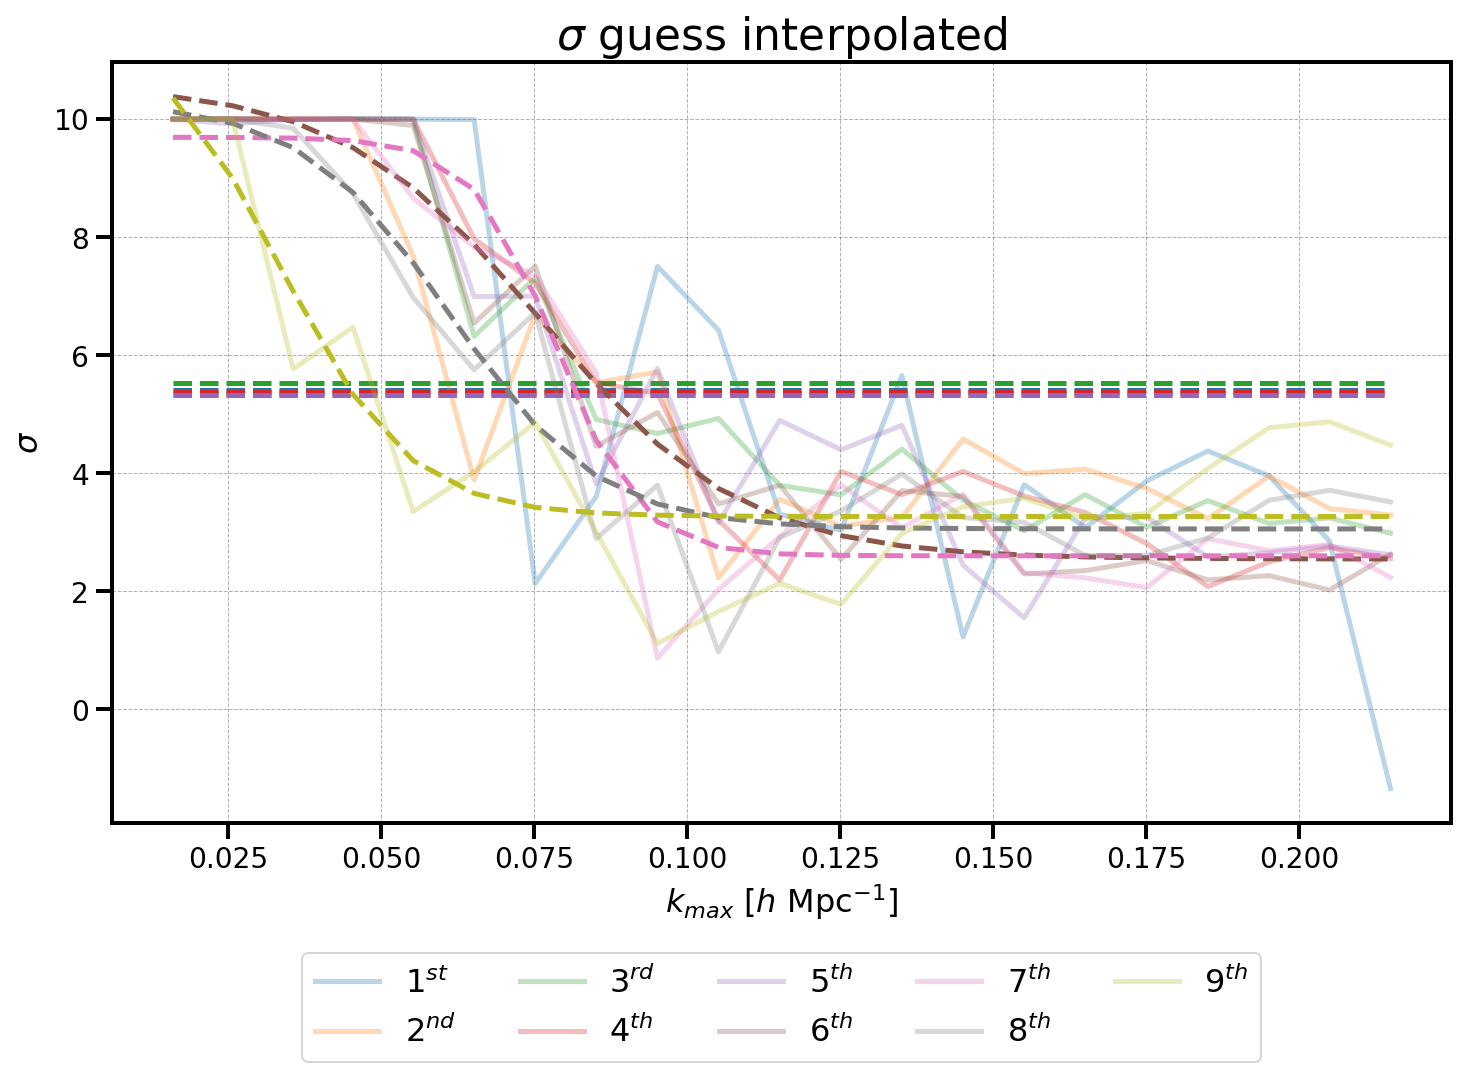

In [11]:
for i in range(n_ptile):
    if i in [0]:
        continue
    popt, pcov = curve_fit(FD_like, kmax_range, sigma_guess[i])
    trend = FD_like(kmax_range, *popt)
    line, = plt.plot(kmax_range, sigma_guess[i], label=ptile_labels[i], alpha=0.3)
    plt.plot(kmax_range, trend, c=line.get_color(), linestyle='--')
    
plt.title('$\sigma$ guess interpolated')
plt.xlabel(r'$k_{max}$ [$h \ \mathrm{Mpc}^{-1}$]')
plt.ylabel(r'$\sigma$')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()